# Curvilinear grids


Parcels also supports [curvilinear grids](https://www.nemo-ocean.eu/doc/node108.html) such as those used in the [NEMO models](https://www.nemo-ocean.eu/).

We will be using the example data in the `NemoCurvilinear_data/` directory. These fields are a purely zonal flow on an aqua-planet (so zonal-velocity is 1 m/s and meridional-velocity is 0 m/s everywhere, and no land). However, because of the curvilinear grid, the `U` and `V` fields vary north of 20N.


In [1]:
from datetime import timedelta as delta

import numpy as np

from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ParticleFile,
    ParticleSet,
    download_example_dataset,
    plotTrajectoriesFile,
)

%matplotlib inline

We can create a `FieldSet` just like we do for normal grids.
Note that NEMO is discretised on a C-grid. U and V velocities are not located on the same nodes (see https://www.nemo-ocean.eu/doc/node19.html ).

```
 __V1__
|      |
U0     U1
|__V0__|
```

To interpolate U, V velocities on the C-grid, Parcels needs to read the f-nodes, which are located on the corners of the cells (for indexing details: https://www.nemo-ocean.eu/doc/img360.png ).


In [2]:
example_dataset_folder = download_example_dataset("NemoCurvilinear_data")
filenames = {
    "U": {
        "lon": f"{example_dataset_folder}/mesh_mask.nc4",
        "lat": f"{example_dataset_folder}/mesh_mask.nc4",
        "data": f"{example_dataset_folder}/U_purely_zonal-ORCA025_grid_U.nc4",
    },
    "V": {
        "lon": f"{example_dataset_folder}/mesh_mask.nc4",
        "lat": f"{example_dataset_folder}/mesh_mask.nc4",
        "data": f"{example_dataset_folder}/V_purely_zonal-ORCA025_grid_V.nc4",
    },
}
variables = {"U": "U", "V": "V"}

dimensions = {"lon": "glamf", "lat": "gphif", "time": "time_counter"}

field_set = FieldSet.from_nemo(
    filenames, variables, dimensions, allow_time_extrapolation=True
)

And we can plot the `U` field.


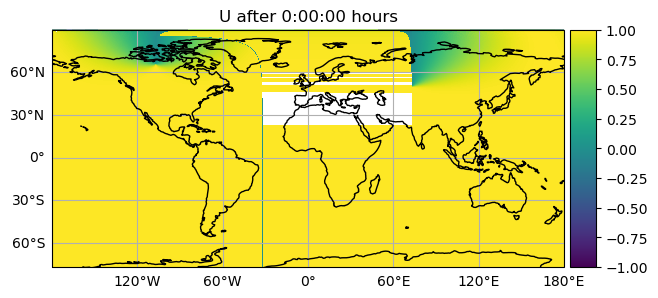

In [3]:
field_set.U.show()

As you see above, the `U` field indeed is 1 m/s south of 20N, but varies with longitude and latitude north of that

Now we can run particles as normal. Parcels will take care to rotate the `U` and `V` fields


In [4]:
# Start 20 particles on a meridional line at 180W
npart = 20
lonp = -180 * np.ones(npart)
latp = [i for i in np.linspace(-70, 88, npart)]


# Create a periodic boundary condition kernel
def periodicBC(particle, fieldset, time):
    if particle.lon > 180:
        particle.lon -= 360


pset = ParticleSet.from_list(field_set, JITParticle, lon=lonp, lat=latp)
pfile = ParticleFile("nemo_particles", pset, outputdt=delta(days=1))
kernels = pset.Kernel(AdvectionRK4) + periodicBC
pset.execute(kernels, runtime=delta(days=50), dt=delta(hours=6), output_file=pfile)

INFO: Compiled ArrayJITParticleAdvectionRK4periodicBC ==> /var/folders/1n/500ln6w97859_nqq86vwpl000000gr/T/parcels-504/lib73e9404215a7e571966b1f3ee2105813_0.so


And then we can plot these trajectories. As expected, all trajectories go exactly zonal and due to the curvature of the earth, ones at higher latitude move more degrees eastward (even though the distance in km is equal for all particles)


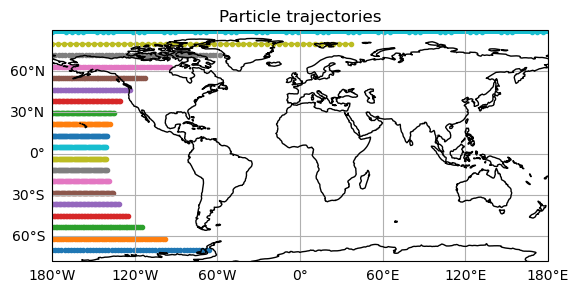

In [5]:
plotTrajectoriesFile("nemo_particles.zarr");

## Speeding up `ParticleSet` initialisation by efficiently finding particle start-locations on the `Grid`

On a Curvilinear grid, determining the location of each `Particle` on the grid is more complicated and therefore takes longer than on a Rectilinear grid. Since Parcels version 2.2.2, a function is available on the `ParticleSet` class, that speeds up the look-up. After creating the `ParticleSet`, but before running the `ParticleSet.execute()`, simply call the function `ParticleSet.populate_indices()`. Note that this only works if you have the [pykdtree](https://anaconda.org/conda-forge/pykdtree) package installed, which is only included in the Parcels dependencies in version >= 2.2.2


In [6]:
pset = ParticleSet.from_list(field_set, JITParticle, lon=lonp, lat=latp)
pset.populate_indices()